#NAME: DISHANG DALWADI

#REG.NO.: 24-27-12

#M.Tech. Data Science

#DLCV -> Lab Assignment

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.signal import butter, filtfilt
import os

In [8]:
# === CONFIGURATION === #
SAMPLE_FREQ = 512  # Hz
ALPHA_BAND = (8, 13)  # Hz
EPOCH_LENGTH = 10  # second
print("D:\\REAL ANALYSIS\\Desktop\\Original_Data.xlsx")

D:\REAL ANALYSIS\Desktop\Original_Data.xlsx


In [9]:
# === Load Excel Sheets === #
file_path = "D:\\REAL ANALYSIS\\Desktop\\Original_Data.xlsx"
ecbl_df = pd.read_excel(file_path, sheet_name='ECBL')
eobl_df = pd.read_excel(file_path, sheet_name='EOBL')
print("✅ ECBL Data Sample:")
print(ecbl_df.head())

print("\n✅ EOBL Data Sample:")
print(eobl_df.head())

electrodes = ecbl_df.columns[1:]  # Skip time column

✅ ECBL Data Sample:
          C3        C4       CP1       CP2        CP5        CP6        F3  \
0 -12158.392 -1708.153 -7909.224 -5345.700 -20866.785 -30006.186 -2108.885   
1 -12161.272 -1702.978 -7910.250 -5342.673 -20866.150 -30010.238 -2111.425   
2 -12164.886 -1697.460 -7908.492 -5336.228 -20869.031 -30012.338 -2119.823   
3 -12166.302 -1701.171 -7905.611 -5329.489 -20872.352 -30011.996 -2128.905   
4 -12159.563 -1712.792 -7900.093 -5322.849 -20874.988 -30008.773 -2132.811   

         F4         F7         F8  ...         Oz         P3         P4  \
0 -8730.513 -35312.090 -33744.660  ... -22771.473 -11085.395 -11522.797   
1 -8733.394 -35315.605 -33745.586  ... -22771.326 -11087.348 -11524.896   
2 -8739.009 -35326.203 -33759.211  ... -22771.375 -11088.178 -11524.457   
3 -8749.849 -35336.164 -33769.563  ... -22767.566 -11088.080 -11518.061   
4 -8759.126 -35337.871 -33759.063  ... -22764.246 -11084.906 -11510.248   

          P7         P8         Pz         T7         T8    

In [10]:
# ===Bandpass Filter === #
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

In [12]:
# ===Alpha Spindle Detection (Simple Thresholding) === #
def detect_spindles(signal, threshold=2.5):
    power = signal ** 2
    return np.where(power > threshold * np.mean(power))[0]

In [13]:
# === Count Spindles per Electrode === #
def count_spindles_all(df):
    spindle_counts = {}
    for ch in electrodes:
        filtered = bandpass_filter(df[ch], *ALPHA_BAND, SAMPLE_FREQ)
        spindles = detect_spindles(filtered)
        spindle_counts[ch] = len(spindles)
    return spindle_counts

ecbl_counts = count_spindles_all(ecbl_df)
eobl_counts = count_spindles_all(eobl_df)

In [14]:
# ===Comparison and Summary === #
summary_df = pd.DataFrame({
    'Electrode': electrodes,
    'ECBL Spindles': [ecbl_counts[ch] for ch in electrodes],
    'EOBL Spindles': [eobl_counts[ch] for ch in electrodes]
})
summary_df['Difference'] = summary_df['EOBL Spindles'] - summary_df['ECBL Spindles']
print("\n✅ Spindle Count Summary:")
print(summary_df)


✅ Spindle Count Summary:
   Electrode  ECBL Spindles  EOBL Spindles  Difference
0         C4           8099           8293         194
1        CP1           8754           8329        -425
2        CP2           8239           8469         230
3        CP5           8989           7722       -1267
4        CP6           8428           7685        -743
5         F3           8564           8267        -297
6         F4           8423           7595        -828
7         F7           8520           8360        -160
8         F8           8139           7939        -200
9         Fz           8356           7472        -884
10       FC1           8297           8409         112
11       FC2           8159           8199          40
12       FC5           8329           8486         157
13       FC6           8528           8673         145
14       Fp1           8200           3468       -4732
15       Fp2           8325           3246       -5079
16       FT9           8691           8

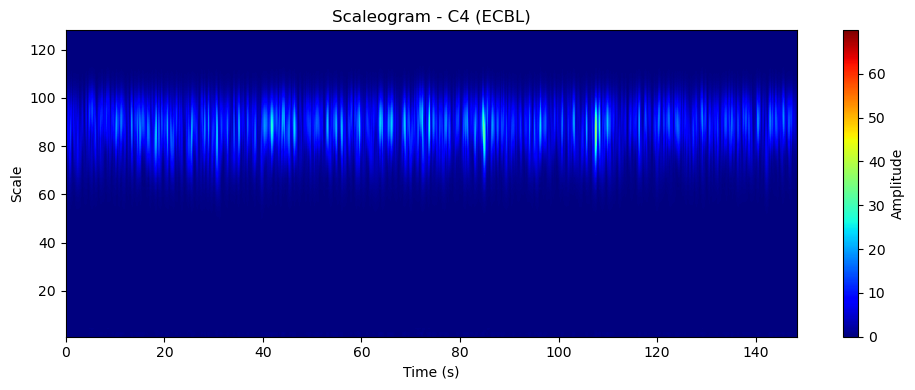

In [16]:
# ===Wavelet Visualization === #
def plot_scaleogram(signal, title="Scaleogram"):
    scales = np.arange(1, 128)
    coef, _ = pywt.cwt(signal, scales, 'morl', sampling_period=1/SAMPLE_FREQ)
    plt.figure(figsize=(10, 4))
    plt.imshow(np.abs(coef), extent=[0, len(signal)/SAMPLE_FREQ, 1, 128], cmap='jet', aspect='auto')
    plt.colorbar(label='Amplitude')
    plt.title(title)
    plt.ylabel('Scale')
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()
# Example usage to visualize scaleogram for the first electrode of ECBL data
sample_electrode = electrodes[0]

# Apply bandpass filter on the chosen electrode's signal
filtered_signal = bandpass_filter(ecbl_df[sample_electrode], *ALPHA_BAND, SAMPLE_FREQ)

# Plot the scaleogram
plot_scaleogram(filtered_signal, f"Scaleogram - {sample_electrode} (ECBL)")



✅ Showing scaleogram for electrode: C4


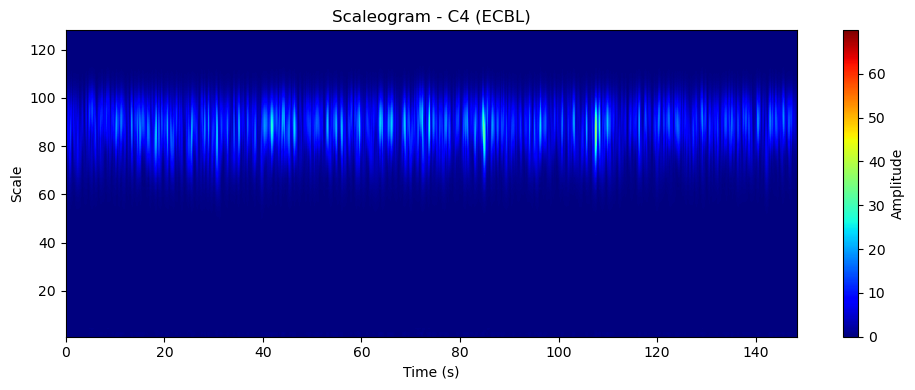

In [17]:
# Example: Plot for first electrode
sample_electrode = electrodes[0]
filtered_signal = bandpass_filter(ecbl_df[sample_electrode], *ALPHA_BAND, SAMPLE_FREQ)
print(f"\n✅ Showing scaleogram for electrode: {sample_electrode}")
plot_scaleogram(filtered_signal, f"Scaleogram - {sample_electrode} (ECBL)")

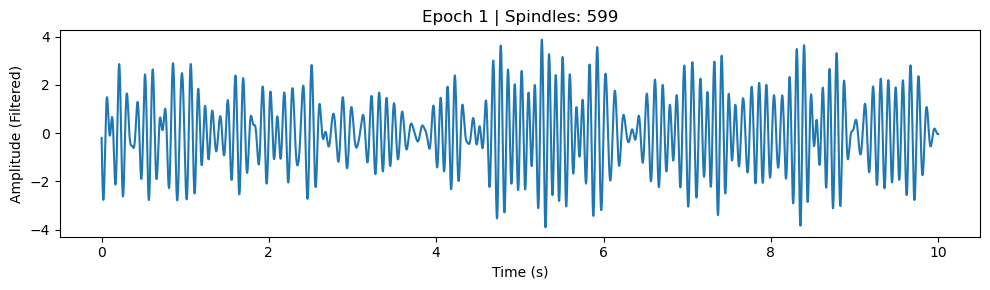

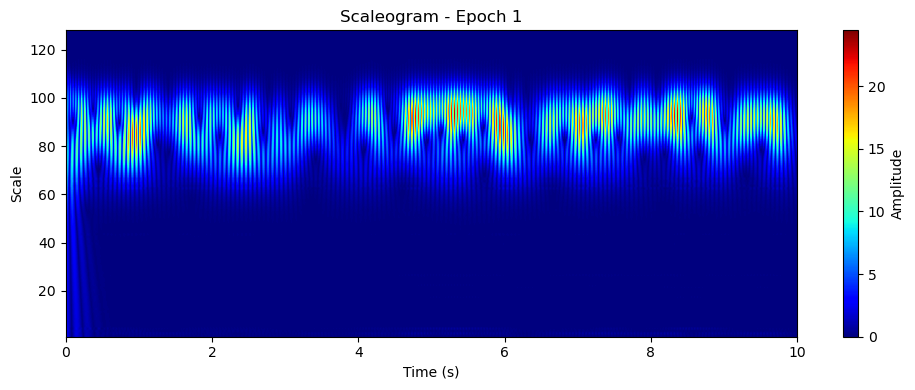

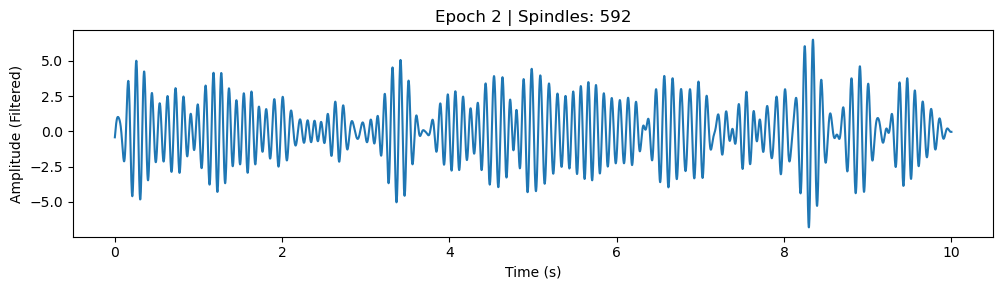

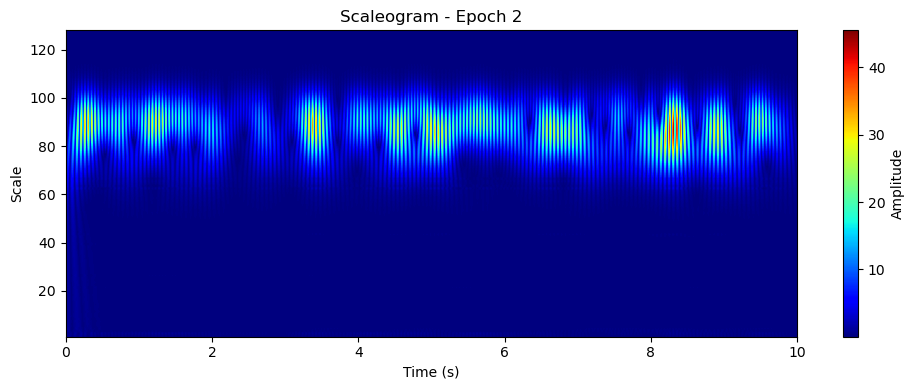

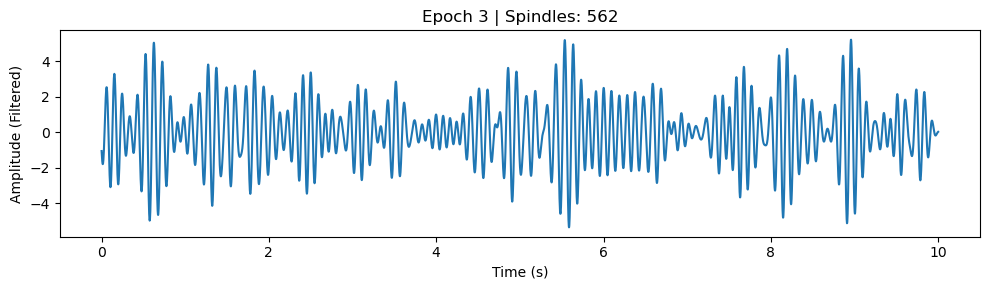

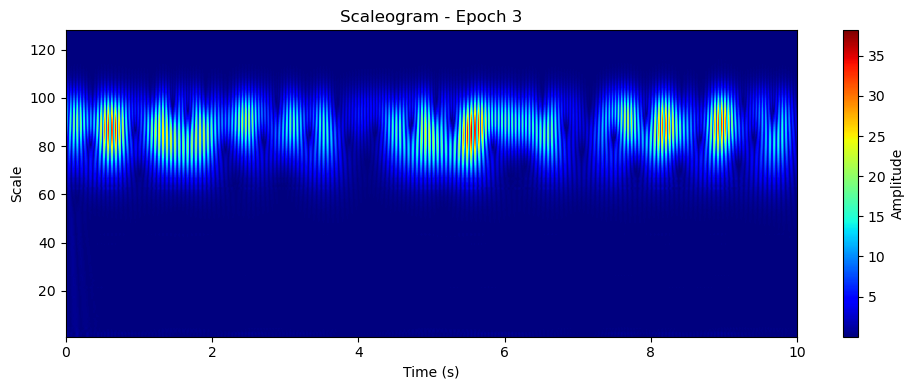

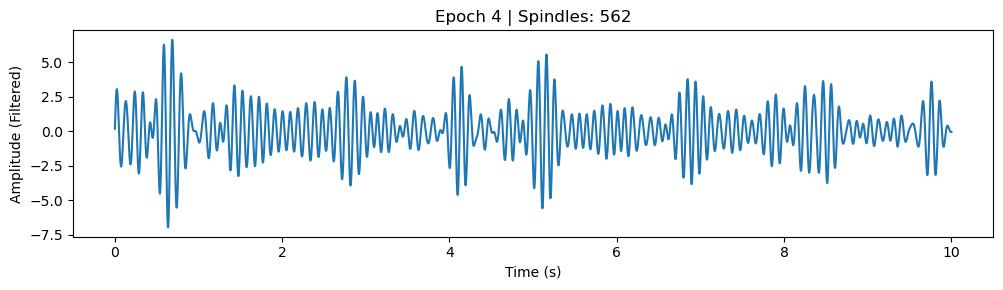

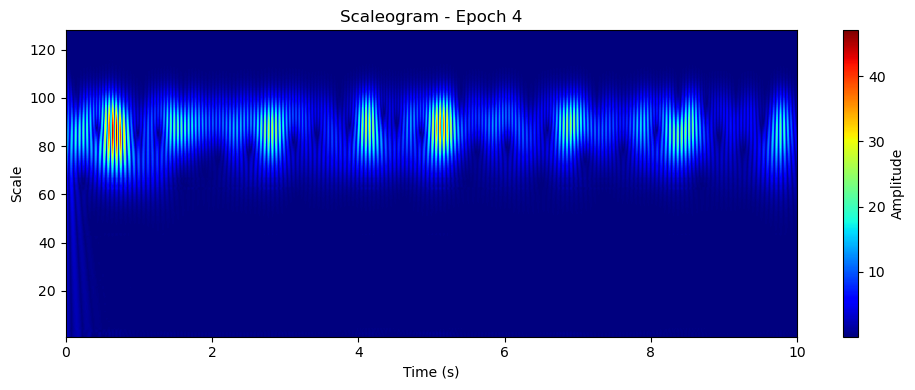

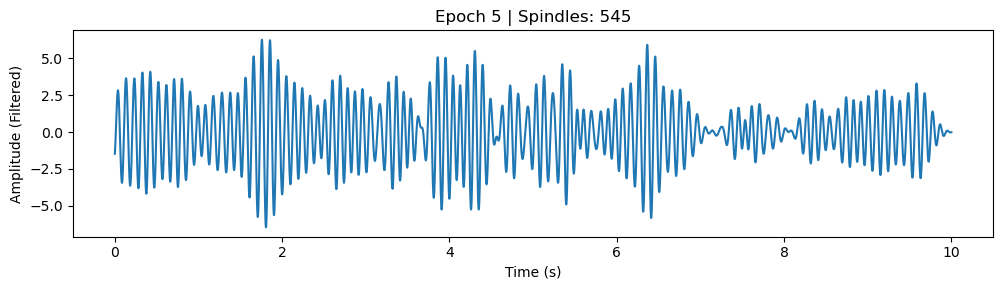

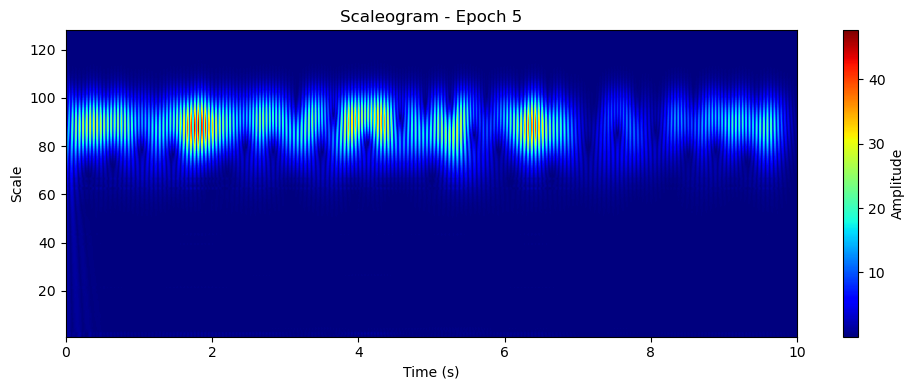

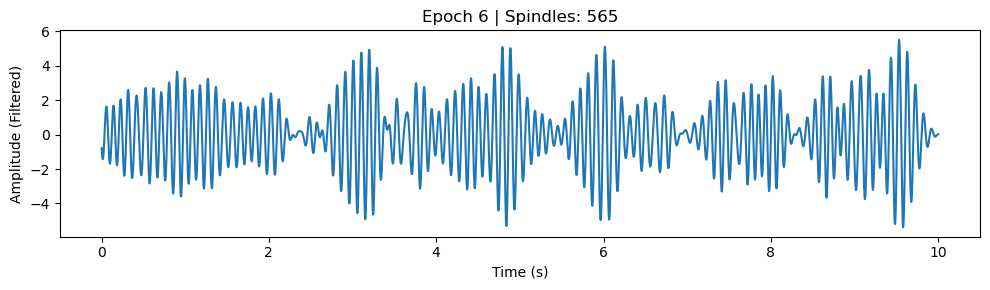

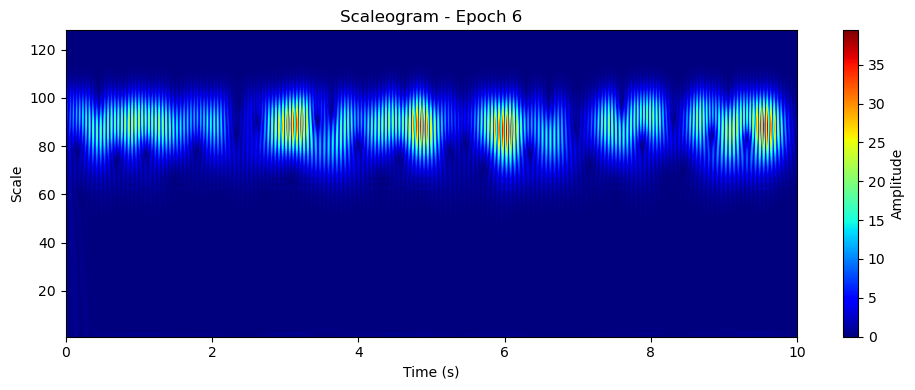

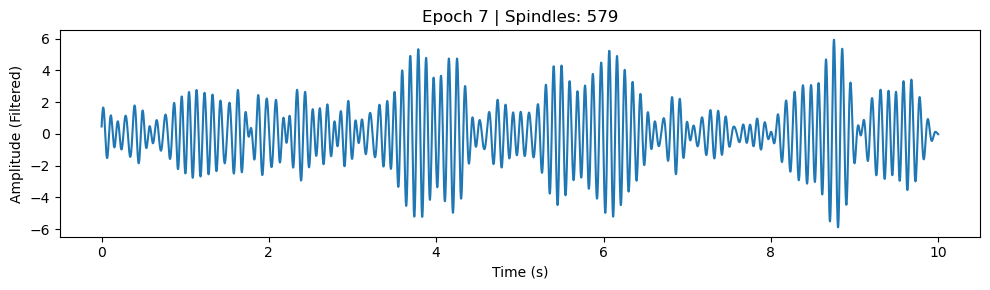

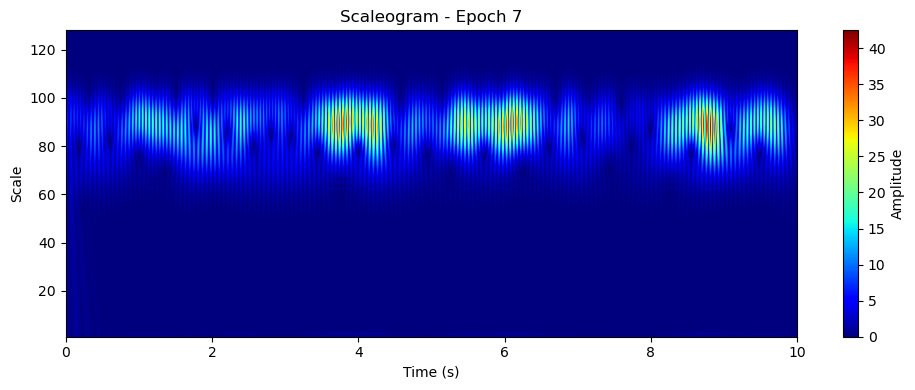

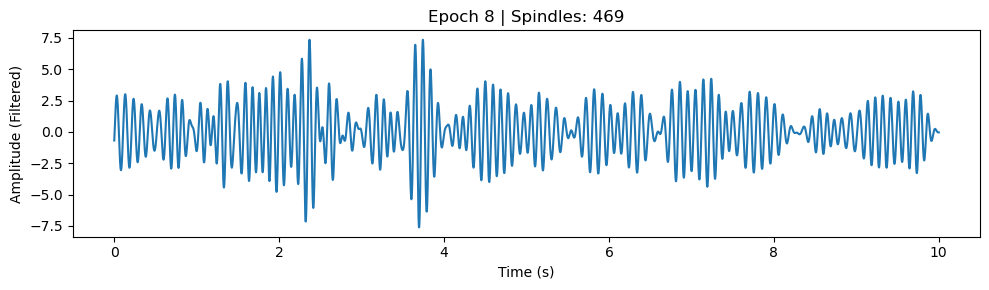

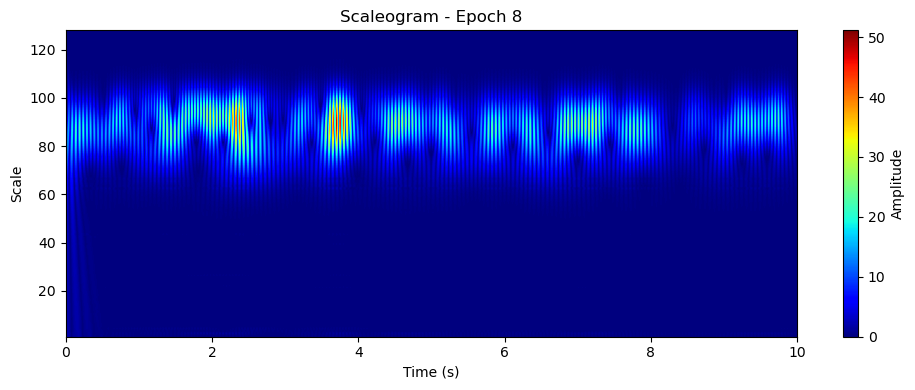

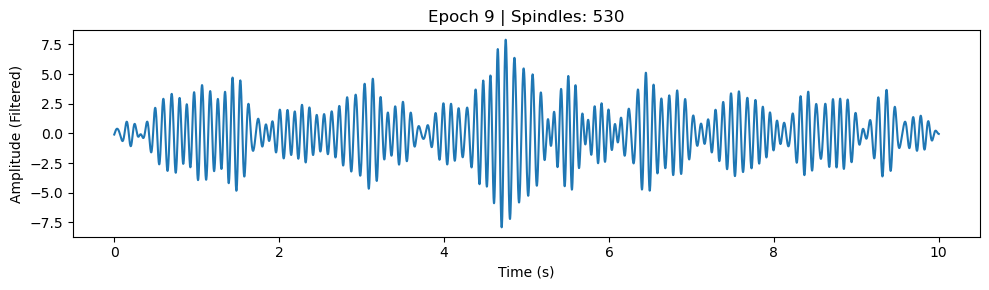

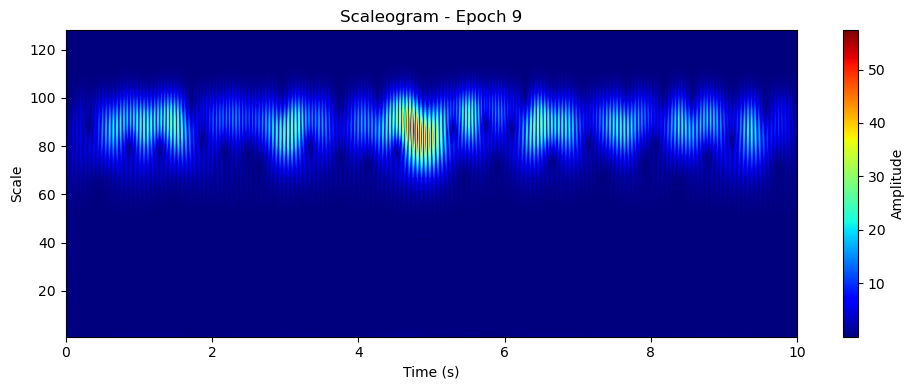

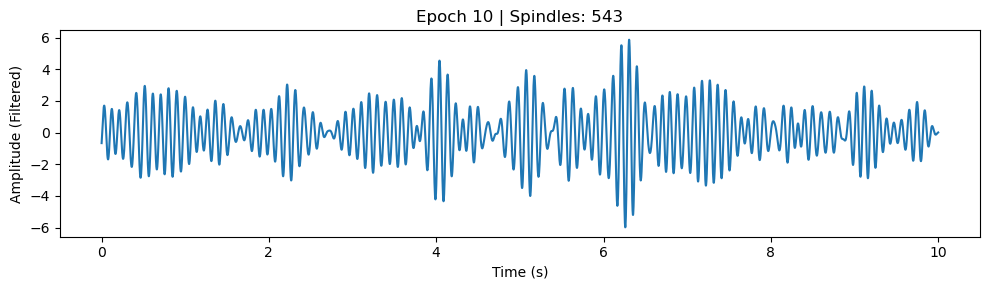

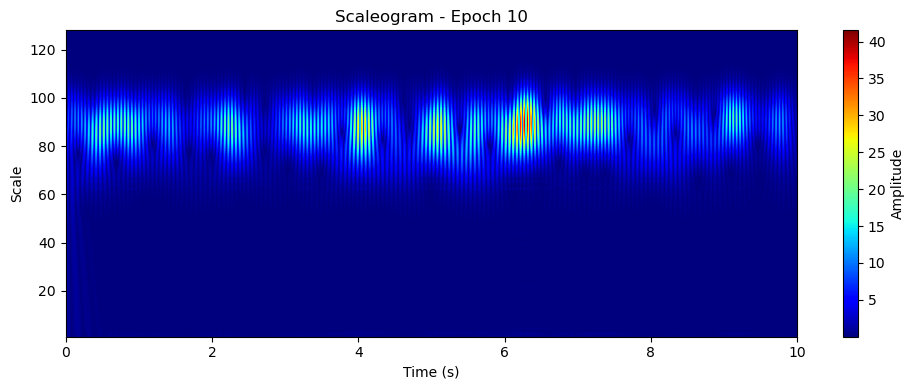

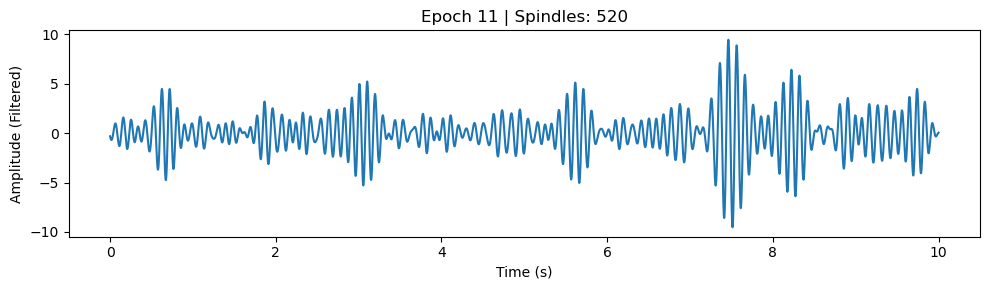

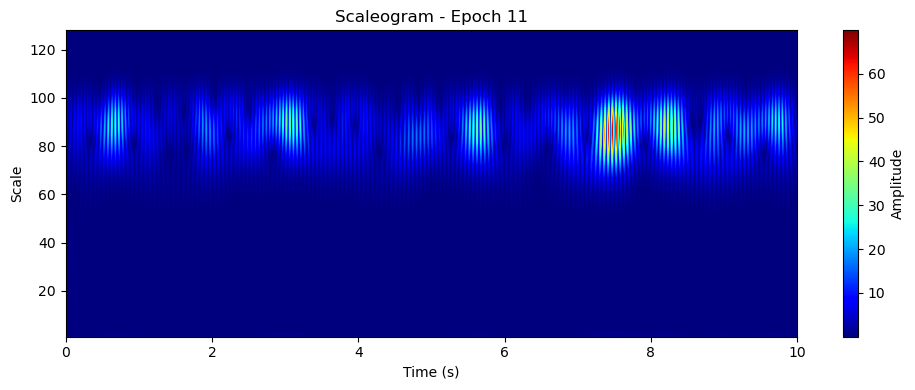

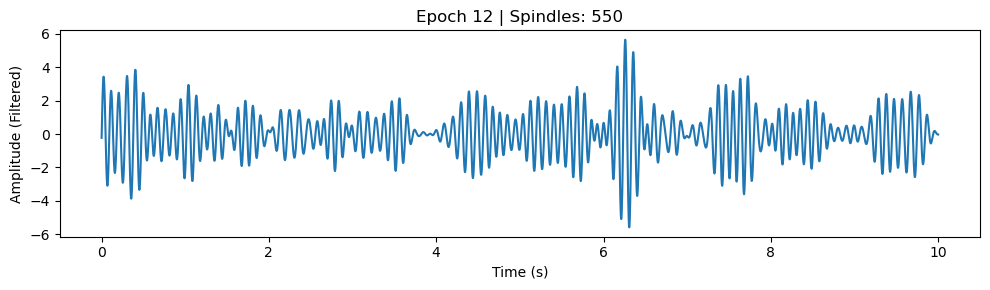

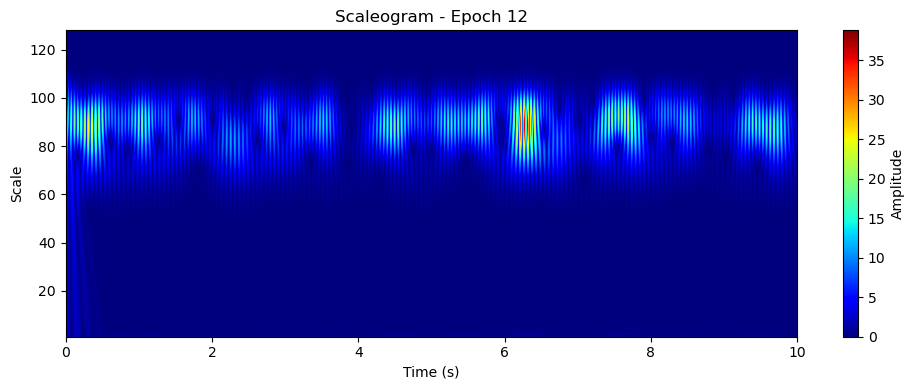

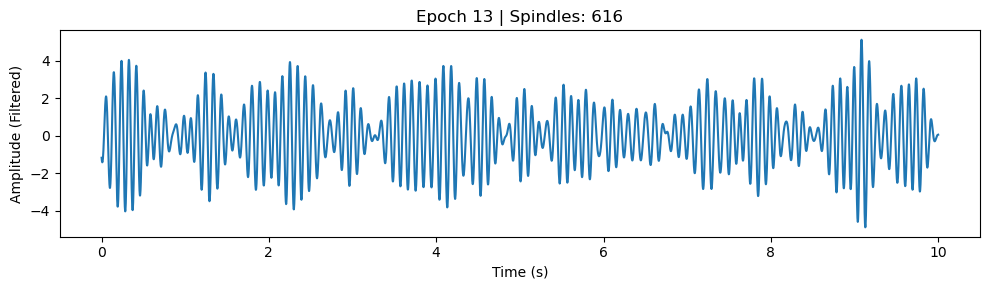

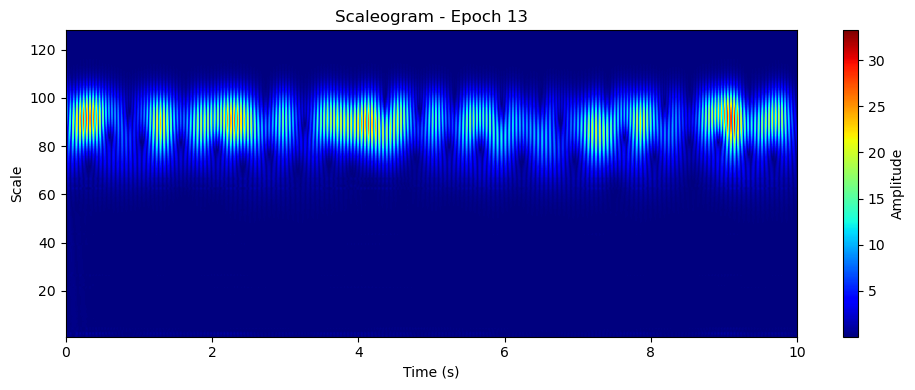

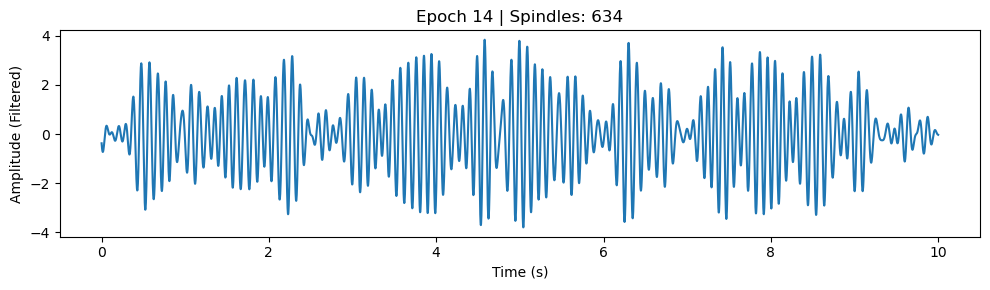

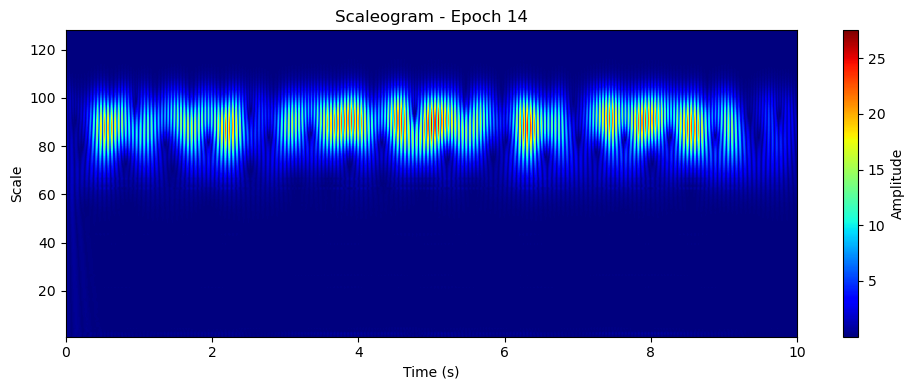

In [18]:
# === Epoch-based Spindle Visualization and Count === #
def epoch_spindle_analysis(df, channel):
    data = df[channel]
    n_samples = len(data)
    samples_per_epoch = EPOCH_LENGTH * SAMPLE_FREQ
    num_epochs = n_samples // samples_per_epoch

    for i in range(num_epochs):
        start = i * samples_per_epoch
        end = start + samples_per_epoch
        epoch_data = data[start:end]
        filtered = bandpass_filter(epoch_data, *ALPHA_BAND, SAMPLE_FREQ)
        spindles = detect_spindles(filtered)

        plt.figure(figsize=(10, 3))
        plt.plot(np.linspace(0, EPOCH_LENGTH, samples_per_epoch), filtered)
        plt.title(f"Epoch {i+1} | Spindles: {len(spindles)}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (Filtered)")
        plt.tight_layout()
        plt.show()

        plot_scaleogram(filtered, f"Scaleogram - Epoch {i+1}")

epoch_spindle_analysis(ecbl_df, sample_electrode)